Define the grid

In [15]:
import numpy as np
import pyvista as pv

nxy_dims = 256
nxy = int(nxy_dims * 1)
dims = np.array([nxy, nxy, 1])
dims_plus1 = [dims[0] + 1, dims[1] + 1, dims[2]]
spacing = (nxy_dims / dims[0], nxy_dims / dims[1], 1)
grid = pv.UniformGrid(
    dims=dims_plus1,
    spacing=spacing,
    origin=(0, 0, 0),
)
points_t = np.transpose(grid.points.T)

Find countour points

In [16]:
import cv2 as cv
from matplotlib.path import Path
import matplotlib.patches as patches

name = 'OAS1_0001_MR1_69_ccseg.tif'
input_path = 'images/oas1'
image_memory = cv.imread(f'{input_path}/{name}')
inverted_image = cv.bitwise_not(image_memory)
img_gray = cv.cvtColor(inverted_image, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(img_gray, 150, 255, cv.THRESH_BINARY)
im2, contours, hierarchy = cv.findContours(image=thresh, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_NONE)

multi_points = []
for contour in contours:
    contour_points = contour[:,0]
    path = Path(contour_points, closed=True)
    patch = patches.PathPatch(path, facecolor=None, lw=1, antialiased=True)
    vertices = patch.get_path().vertices
    trans = patch.get_patch_transform()
    points = trans.transform(vertices)
    multi_points.append(points)

Define point clouds

In [17]:
from shapely.geometry import Polygon, MultiPolygon, Point

multi_multipolygon = []
for points in multi_points:
    poly = Polygon(points)
    poly_big = poly.buffer(1e-6)
    if poly_big.geom_type == 'MultiPolygon':
        pass
    elif poly_big.geom_type == 'Polygon':
        poly_big = MultiPolygon([poly_big])
    else:
        pass
    multi_multipolygon.append(poly_big)

points_i = []
points_i_only = []
for i, o in enumerate(points_t):
    point = Point(o[:2])
    inserted = False
    for multipolygon in multi_multipolygon:
        if multipolygon.contains(point):
            points_i_only.append(o)
            inserted = True
            break
    points_i.append(1 if inserted else 0)

Find Points square and Points type

In [18]:
cxy = dims[0] * dims[1]
cx = dims[0]
cxy_plus1 = dims_plus1[0] * dims_plus1[1]
cx_plus1 = dims_plus1[0]

points_square = []
points_type = []

for i in np.arange(0, np.prod(dims), 1, dtype=np.int):
    dz = i // cxy                                       # i div (dimension x and y) to get axis z
    dz_r = i - (dz * cxy)                               # get the remaining of dz
    dy = dz_r // cx                                     # remain of dz div (dimension of x) to get axis y
    dy_r = dz_r - (dy * cx)                             # get the remaining of dy
    dx = dy_r                                           # get the dx

    pt = dz * cxy_plus1 + dy * cx_plus1 + dx * 1        # mapping value to match array of points
    p0 = pt                                             # find the lowest x
    p1 = pt + 1                                         # find the lowest x + 1
    p2 = p0 + cx_plus1                                  # find the lowest x with y + 1
    p3 = p1 + cx_plus1                                  # find the lowest x + 1 with y + 1

    points_square.append(
        np.array(
            [
                points_t[p0],
                points_t[p1],
                points_t[p2],
                points_t[p3]
            ]
        )
    )

    points_type.append(
        (points_i[p0] << 3) + (points_i[p1] << 2) + (points_i[p2] << 1) + (points_i[p3] << 0)
    )

Draw the pointclouds to grid, a.k.a reconstruct


In [19]:
import math
import marching_2d_rules_1 as rules

def num_digits(n):
    if n > 0:
        digits = int(math.log10(n)) + 1
    elif n == 0:
        digits = 1
    else:
        digits = int(math.log10(-n)) + 2
    return digits

dictionary = {}
points_p = []
faces_p = []

digit_x = 10 ** (num_digits(nxy) + 1)
digit_y = 10 ** (num_digits(nxy) + 1)

max_z = digit_x * digit_y
max_y = digit_x

for i, o in enumerate(points_square):
    poly_points = rules.to_points(o, points_type[i])
    position = []
    for poly_point in poly_points:
        magnitude = poly_point[0] + (max_y * (poly_point[1] + 1)) + (max_z * (poly_point[2] + 1))
        if dictionary.get(magnitude) is None:
            points_p.append(poly_point)
            dictionary[magnitude] = len(points_p) - 1
        position.append(dictionary[magnitude])
    for poly_face in rules.to_faces(position, points_type[i]):
        faces_p.append(poly_face)

polyline = pv.PolyData(points_p, faces=np.array(faces_p).flatten())

Add extrusion

In [20]:
polyline = polyline.extrude((0, 0, 1), capping=True)
polyline = polyline.clean()

Export to obj

In [21]:
output_path = 'objs'
polyline.save(f'{output_path}/{name}.stl')

Show

/Users/engineering/Documents/anaconda3/envs/shapely-pyvista/lib/python3.6/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


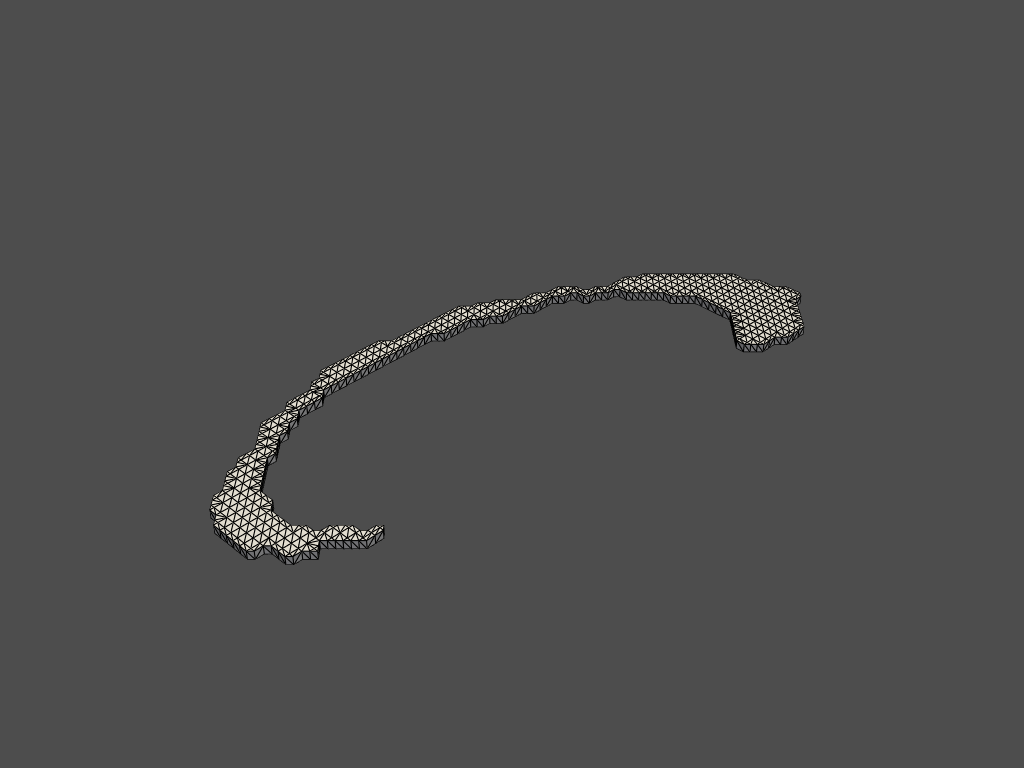

In [22]:
plot = pv.Plotter()
plot.add_mesh(polyline, show_edges=True)
plot.show()